Team Members:
*   Amir Mobayen
*   Leelav Kareem
*   Nikita Chistyakov

## Fully Connected Neural Network

In [1]:
# Basic packages
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Tensorflow and Tensorflow Hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.get_logger().setLevel('ERROR')


In [2]:
from google.colab import files
uploaded = files.upload()
data_file = 'train.txt'
test_file = 'test.txt'

Saving test.txt to test (1).txt
Saving train.txt to train (1).txt


In [11]:
train_data = pd.read_csv(data_file, delimiter=';', names=['text', 'label'])
test_data = pd.read_csv(test_file, delimiter=';', header=0, names=['text', 'label'])

train_data.head(), test_data.head()

(                                                text    label
 0                            i didnt feel humiliated  sadness
 1  i can go from feeling so hopeless to so damned...  sadness
 2   im grabbing a minute to post i feel greedy wrong    anger
 3  i am ever feeling nostalgic about the fireplac...     love
 4                               i am feeling grouchy    anger,
                                                 text    label
 0          im updating my blog because i feel shitty  sadness
 1  i never make her separate from me because i do...  sadness
 2  i left with my bouquet of red and yellow tulip...      joy
 3    i was feeling a little vain when i did this one  sadness
 4  i cant walk into a shop anywhere where i do no...     fear)

In [130]:


# Load the pre-trained word embedding model from TensorFlow Hub
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")


text_data = train_data['text']
label_data = train_data['label']

#encode label
label_encoder = LabelEncoder()
label_encoder.fit(label_data)
label_data_encoded = label_encoder.transform(label_data)

train_set = tf.data.Dataset.from_tensor_slices((text_data, label_data_encoded))

train_size = len(text_data)

train_set = train_set.shuffle(10000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)


#test set
test_text_data = test_data['text']
test_label_data = test_data['label']


label_data_encoded_test = label_encoder.transform(test_label_data)

test_set = tf.data.Dataset.from_tensor_slices((test_text_data, label_data_encoded_test))

test_size = len(test_text_data)
test_set = test_set.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Tokenization and Padding
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_data)

sequences = tokenizer.texts_to_sequences(text_data)
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_text_data)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [131]:
batch_size = 32

#model
model = tf.keras.models.Sequential([
    hub.KerasLayer(embed, dtype=tf.string, input_shape=[], output_shape=[300]),
    Dense(300, activation="relu"),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(rate=0.6),
    Dense(300, activation="relu"),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(rate=0.6),
    Dense(300, activation="relu"),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(rate=0.6),
    Dense(6, activation="softmax")
])



# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=100,
                    validation_data=test_set, validation_steps=test_size // batch_size,
                    callbacks=[early_stopping])

Epoch 1/100
500/500 [==============================] - 7s 10ms/step - loss: 2.0572 - accuracy: 0.3164 - val_loss: 1.4106 - val_accuracy: 0.4738
Epoch 2/100
500/500 [==============================] - 4s 8ms/step - loss: 1.5195 - accuracy: 0.4161 - val_loss: 1.3547 - val_accuracy: 0.4793
Epoch 3/100
500/500 [==============================] - 5s 9ms/step - loss: 1.4470 - accuracy: 0.4453 - val_loss: 1.3417 - val_accuracy: 0.4773
Epoch 4/100
500/500 [==============================] - 4s 8ms/step - loss: 1.4162 - accuracy: 0.4548 - val_loss: 1.3280 - val_accuracy: 0.4849
Epoch 5/100
500/500 [==============================] - 4s 8ms/step - loss: 1.4046 - accuracy: 0.4501 - val_loss: 1.3172 - val_accuracy: 0.4894
Epoch 6/100
500/500 [==============================] - 5s 10ms/step - loss: 1.3908 - accuracy: 0.4641 - val_loss: 1.3070 - val_accuracy: 0.4950
Epoch 7/100
500/500 [==============================] - 4s 8ms/step - loss: 1.3810 - accuracy: 0.4664 - val_loss: 1.3082 - val_accuracy: 0.48

In [132]:
test_loss, test_accuracy = model.evaluate(test_set, steps=test_size // batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


62/62 [==============================] - 0s 3ms/step - loss: 1.2544 - accuracy: 0.5166
Test Loss: 1.2543654441833496, Test Accuracy: 0.5166330933570862


In [39]:
#plot function
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

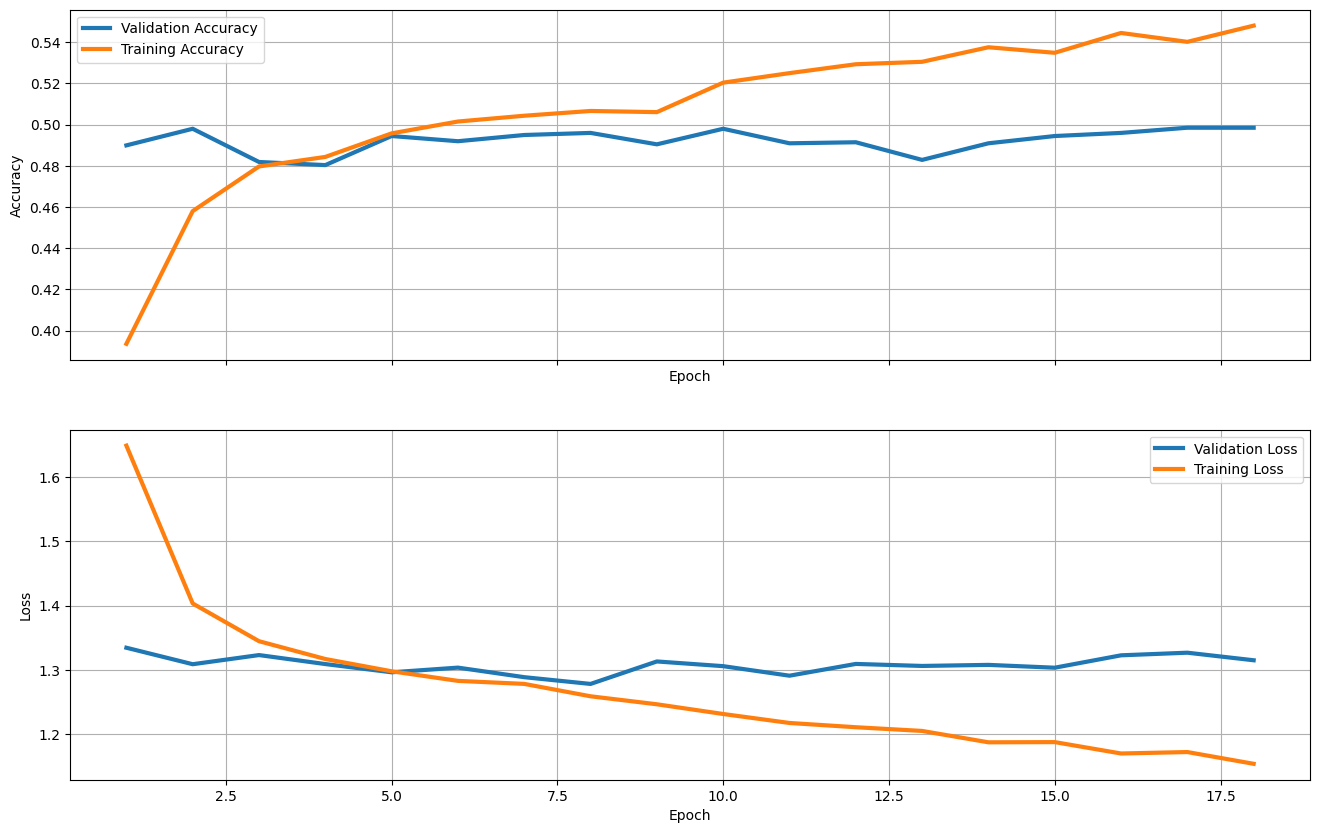

In [57]:
plot_results(history)

## Real Dataset


In [107]:
from google.colab import files
uploaded = files.upload()
real_train = 'train.csv'
real_test = 'test.csv'

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


In [108]:
real_train = pd.read_csv(real_train)
real_test = pd.read_csv(real_test)


In [126]:


# Load and preprocess the train data
text_real = real_train['article_title']
label_real = real_train['is_ecology']

label_encoder = LabelEncoder()
label_encoder.fit(label_real)
label_real_encoded = label_encoder.transform(label_real)

train_set_real = tf.data.Dataset.from_tensor_slices((text_real, label_real_encoded))

train_size_real = len(text_real)
batch_size = 32
train_set_real = train_set_real.shuffle(10000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load and preprocess the test data
test_real_data = real_test['article_title']
test_label_real = real_test['is_ecology']

label_real_encoded_test = label_encoder.transform(test_label_real)

test_set_real = tf.data.Dataset.from_tensor_slices((test_real_data, label_real_encoded_test))

test_size_real = len(test_real_data)
test_set_real = test_set_real.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Tokenization and Padding
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_real)

sequences_real = tokenizer.texts_to_sequences(text_real)
max_sequence_length = 100
padded_sequences_real = pad_sequences(sequences_real, maxlen=max_sequence_length, padding='post', truncating='post')

test_sequences_real = tokenizer.texts_to_sequences(test_real_data)
padded_test_sequences_real = pad_sequences(test_sequences_real, maxlen=max_sequence_length, padding='post', truncating='post')

# Build the model
model = tf.keras.models.Sequential([
    hub.KerasLayer(embed, dtype=tf.string, input_shape=[], output_shape=[300]),
    Dense(300, activation="relu"),
    BatchNormalization(),
    Dropout(rate=0.6),
    Dense(300, activation="relu"),
    BatchNormalization(),
    Dropout(rate=0.6),
    Dense(300, activation="relu"),
    BatchNormalization(),
    Dropout(rate=0.6),
    Dense(1, activation="sigmoid")
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_real = model.fit(train_set_real, steps_per_epoch=train_size_real // batch_size, epochs=100,
                    validation_data=test_set_real, validation_steps=test_size_real // batch_size,
                    callbacks=[early_stopping])




Epoch 1/100
69/69 [==============================] - 3s 15ms/step - loss: 0.8086 - accuracy: 0.6255 - val_loss: 0.4791 - val_accuracy: 0.8160
Epoch 2/100
69/69 [==============================] - 1s 8ms/step - loss: 0.3965 - accuracy: 0.8324 - val_loss: 0.4891 - val_accuracy: 0.8160
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 0.2616 - accuracy: 0.9171 - val_loss: 0.5117 - val_accuracy: 0.8160
Epoch 4/100
69/69 [==============================] - 1s 13ms/step - loss: 0.2027 - accuracy: 0.9461 - val_loss: 0.5062 - val_accuracy: 0.8160
Epoch 5/100
69/69 [==============================] - 1s 12ms/step - loss: 0.1535 - accuracy: 0.9647 - val_loss: 0.5356 - val_accuracy: 0.8160
Epoch 6/100
69/69 [==============================] - 1s 13ms/step - loss: 0.1512 - accuracy: 0.9642 - val_loss: 0.5678 - val_accuracy: 0.8160
Epoch 7/100
69/69 [==============================] - 1s 9ms/step - loss: 0.1480 - accuracy: 0.9724 - val_loss: 0.6264 - val_accuracy: 0.8160
Epoch 8/1

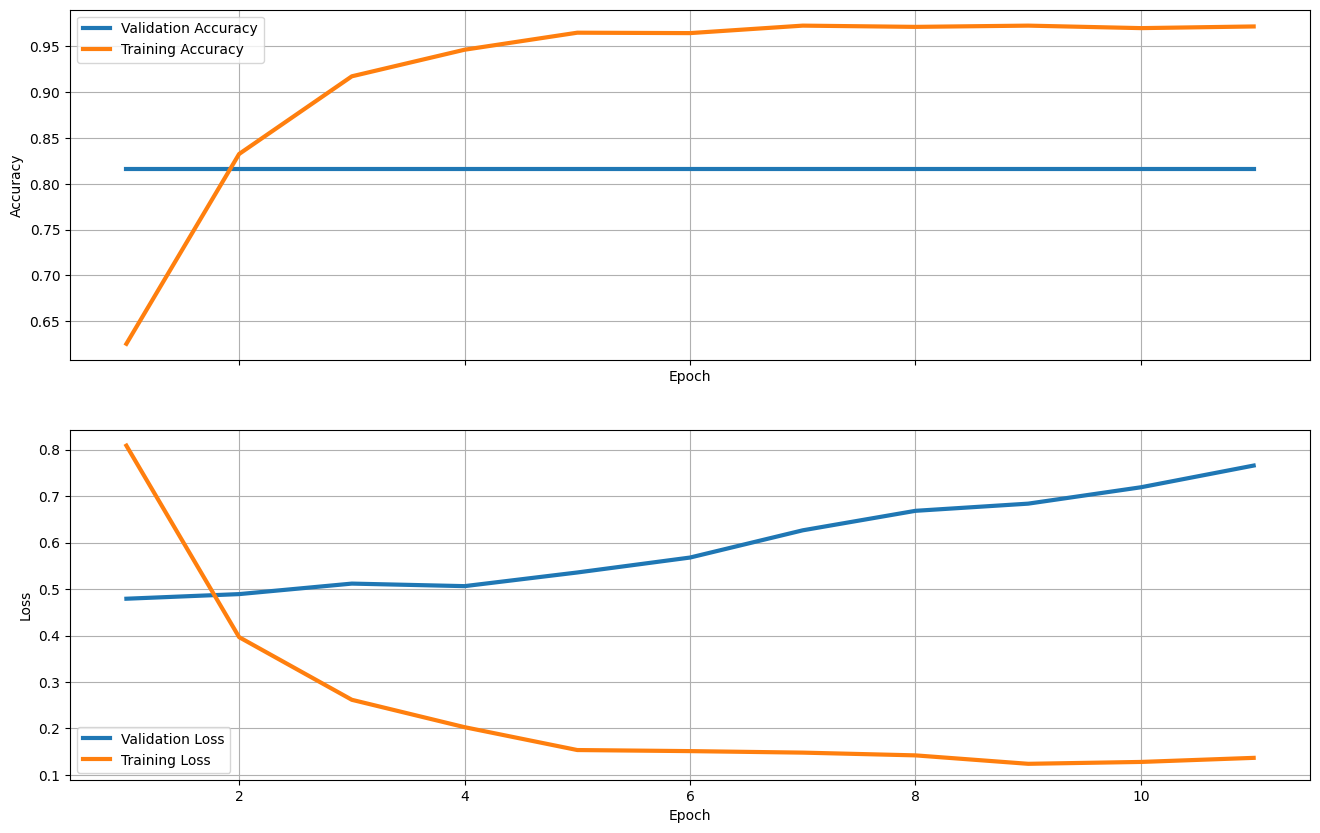

In [127]:
plot_results(history_real)